<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day29_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


**Types:**
- **Point anomalies:** Single unusual instance
- **Contextual anomalies:** Unusual in specific context
- **Collective anomalies:** Group of related anomalies

**Use cases:**
- Fraud detection
- Network intrusion
- Manufacturing defects
- Medical diagnosis

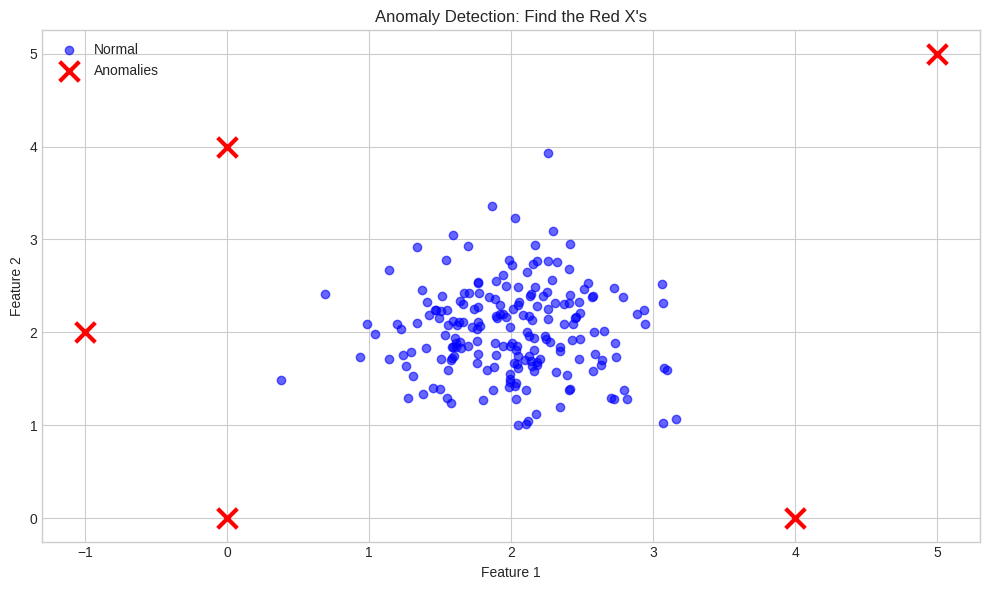

In [2]:
# Visual: What is an anomaly?
np.random.seed(42)

# Normal data
normal = np.random.randn(200, 2) * 0.5 + [2, 2]

# Anomalies
anomalies = np.array([[5, 5], [0, 0], [4, 0], [0, 4], [-1, 2]])

plt.figure(figsize=(10, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', label='Normal', alpha=0.6)
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='x', s=200,
            linewidths=3, label='Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Anomaly Detection: Find the Red X\'s')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
from sklearn.datasets import fetch_kddcup99

kdd = fetch_kddcup99(subset='SA', percent10=True, random_state=42)

x = pd.DataFrame(kdd.data)
y = kdd.target

print(f"Dataset: {x.shape[0]} connections, {x.shape[1]} features")


Dataset: 100655 connections, 41 features


In [4]:
feature_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
                 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
                 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
                 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
                 'num_access_files', 'num_outbound_cmds', 'is_host_login',
                 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
                 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
                 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

if len(feature_names) == x.shape[1]:
  x.columns = feature_names

x.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [5]:
#Checking target distribution
unique, counts = np.unique(y, return_counts=True)
target_df = pd.DataFrame({'Attack Type': unique, 'Count': counts})
target_df = target_df.sort_values(by='Count', ascending=False)

print("Attack type distribution in the dataset:")
print(target_df.head(10).to_string(index=False))

Attack type distribution in the dataset:
    Attack Type  Count
     b'normal.'  97278
      b'smurf.'   2409
    b'neptune.'    898
       b'back.'     15
      b'satan.'     15
    b'ipsweep.'     10
   b'teardrop.'      9
  b'portsweep.'      8
b'warezclient.'      8
        b'pod.'      3


In [6]:
# Create binary labels: normal (0) vs attack (1)
y_binary = np.where(y == b'normal.', 0, 1)

print(f"\nBinary Distribution:")
print(f"  Normal: {(y_binary == 0).sum():,} ({(y_binary == 0).mean():.1%})")
print(f"  Attack: {(y_binary == 1).sum():,} ({(y_binary == 1).mean():.1%})")


Binary Distribution:
  Normal: 97,278 (96.6%)
  Attack: 3,377 (3.4%)


In [7]:
#Handling categorical columns
for col in x.columns:
  if x[col].dtype == object:
    x[col] = x[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

print("Data Types:")
print(x.dtypes.value_counts())

Data Types:
int64      23
float64    15
object      3
Name: count, dtype: int64


In [8]:
#Encoding the categorical features
categorical_col = x.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Features: {categorical_col}")

le_dict = {}
for col in categorical_col:
  le = LabelEncoder()
  x[col] = le.fit_transform(x[col].astype(str))
  le_dict[col] = le

Categorical Features: ['protocol_type', 'service', 'flag']


In [9]:
#Sampling
np.random.seed(42)
sample_size = 10000
sample_idx = np.random.choice(len(x), size=min(sample_size, len(x)), replace=False)

x_sample = x.iloc[sample_idx].values
y_sample = y_binary[sample_idx]

print(f"Sample size: {len(x_sample)}")
print(f"Attack rate in sample: {y_sample.mean():.1%}")

Sample size: 10000
Attack rate in sample: 3.3%


In [10]:
#Scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_sample)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_sample, test_size=0.3, random_state=42, stratify=y_sample)

print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

Train size: 7000
Test size: 3000


##Isolation Forest

**Idea:** Anomalies are easier to isolate (separate) than normal points

**How it works:**
1. Randomly select a feature
2. Randomly select a split value
3. Repeat until point is isolated
4. Anomalies need fewer splits (shorter path)

In [12]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=y_train.mean(),
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(x_train)

# Predicting (-1, anomaly), (1, normal)
y_pred_iso = iso_forest.predict(x_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("Isolation forest results:")
print(classification_report(y_test, y_pred_iso,
      target_names=['Normal', 'Attack']))

Isolation forest results:
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      2902
      Attack       0.35      0.29      0.32        98

    accuracy                           0.96      3000
   macro avg       0.67      0.63      0.65      3000
weighted avg       0.96      0.96      0.96      3000



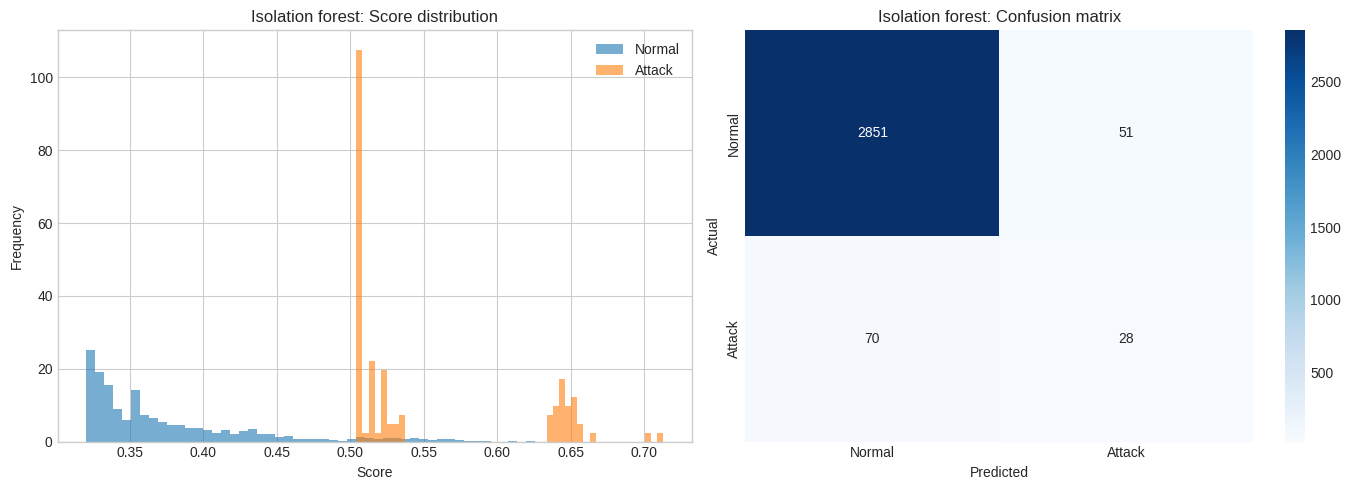

In [13]:
#Anomaly scores
scores_iso = -iso_forest.score_samples(x_test)

#A higher score = high anomaly

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(scores_iso[y_test == 0], bins=50, alpha=0.6, label='Normal', density=True)
axes[0].hist(scores_iso[y_test == 1], bins=50, alpha=0.6, label='Attack', density=True)
axes[0].set_title('Isolation forest: Score distribution')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

#Confusion matrix'
cm = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
axes[1].set_title('Isolation forest: Confusion matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

One-class SVM - Create a boundary around the 'normal' data

In [14]:
x_train_normal = x_train[y_train == 0][:2000]

ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.1     #upper bound on fraction of outliers
)

ocsvm.fit(x_train_normal)

y_pred_ocsvm = ocsvm.predict(x_test)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)

print("One-class SVM results:")
print(classification_report(y_test, y_pred_ocsvm, target_names=['Normal', 'Attack']))

One-class SVM results:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96      2902
      Attack       0.29      1.00      0.45        98

    accuracy                           0.92      3000
   macro avg       0.65      0.96      0.70      3000
weighted avg       0.98      0.92      0.94      3000



## Local Outlier Factor (LOF)

**Idea:** Compare local density of a point to its neighbors

**How it works:**
1. Calculate local density for each point
2. Compare to density of neighbors
3. Lower relative density = anomaly

In [15]:
#local outlier factor
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=y_train.mean(),
    novelty=True,
    n_jobs=-1
)

lof.fit(x_train)

y_pred_lof = lof.predict(x_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

print('Local Outlier Factor results:')
print(classification_report(y_test, y_pred_lof, target_names=['Normal', 'Attack']))

Local Outlier Factor results:
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97      2902
      Attack       0.26      0.28      0.27        98

    accuracy                           0.95      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.95      0.95      0.95      3000



Comparing all methods

In [16]:
results = {
    'Isolation Forest': y_pred_iso,
    'One-Class SVM': y_pred_ocsvm,
    'LOF': y_pred_lof
}

from sklearn.metrics import precision_score, recall_score

comparison_data = []
for name, pred in results.items():
  prec = precision_score(y_test, pred)
  rec = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  comparison_data.append({'Method': name, 'Precision': prec, "Recall": rec, 'F1': f1})
  print(f"{name:<20} {prec:<12.4f} {rec:<12.4f} {f1:<12.4}")

comparison_df = pd.DataFrame(comparison_data)

Isolation Forest     0.3544       0.2857       0.3164      
One-Class SVM        0.2917       1.0000       0.4516      
LOF                  0.2571       0.2755       0.266       


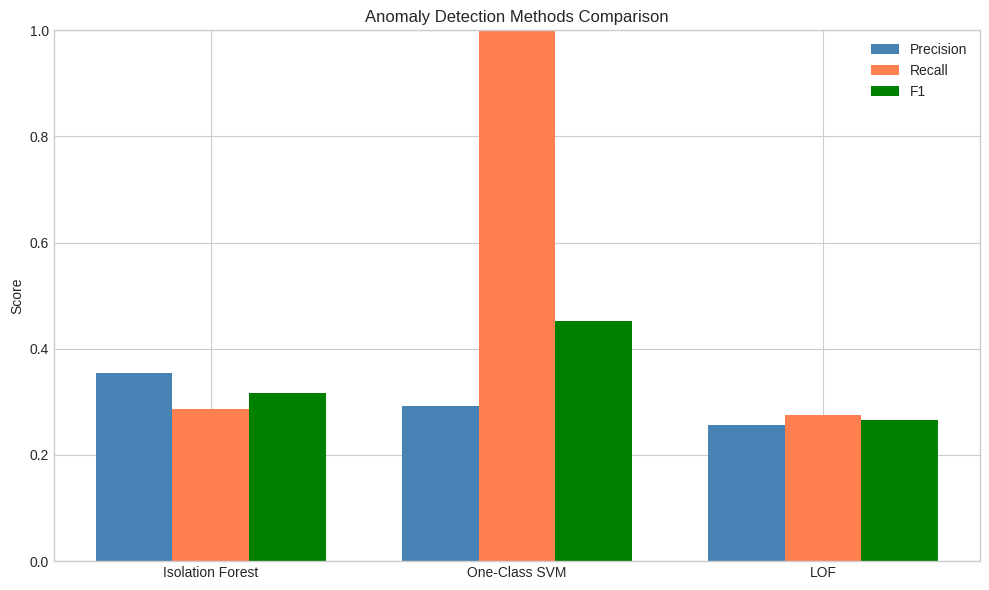

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width=0.25

ax.bar(x - width, comparison_df['Precision'], width, label='Precision', color='steelblue')
ax.bar(x, comparison_df['Recall'], width, label='Recall', color='coral')
ax.bar(x + width, comparison_df['F1'], width, label='F1', color='green')

ax.set_title('Anomaly Detection Methods Comparison')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Method'])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Tuning Contamination Parameter

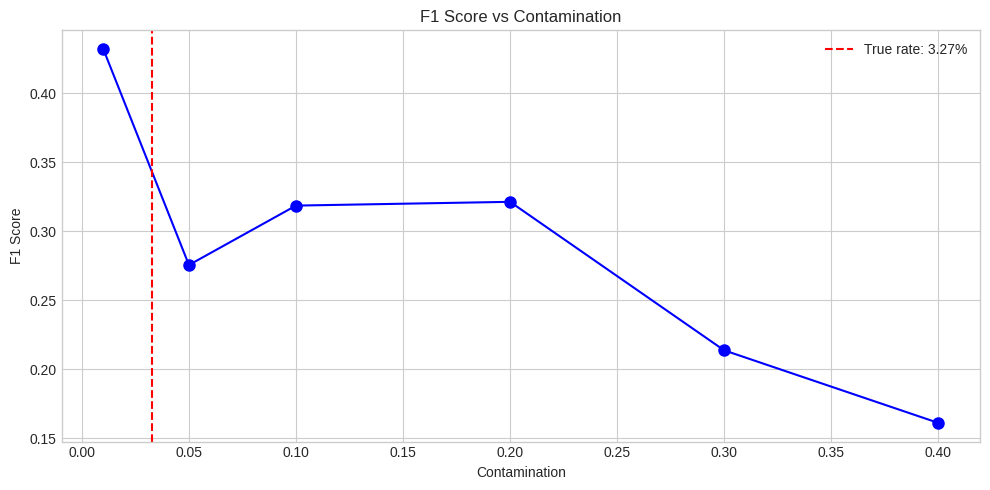

In [21]:
contaminations = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
f1_scores = []

for cont in contaminations:
  iso = IsolationForest(n_estimators=100, contamination=cont, random_state=42, n_jobs=-1)
  iso.fit(x_train)
  pred = iso.predict(x_test)
  pred = np.where(pred == -1, 1, 0)
  f1_scores.append(f1_score(y_test, pred))

plt.figure(figsize=(10, 5))
plt.plot(contaminations, f1_scores, 'b-o', markersize=8)
plt.axvline(x=y_test.mean(), color='red', linestyle='--', label=f'True rate: {y_test.mean():.2%}')
plt.xlabel("Contamination")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Contamination")
plt.legend()
plt.tight_layout()
plt.show()

Feature Importance (Isolation Forest)

Computing feature importance...


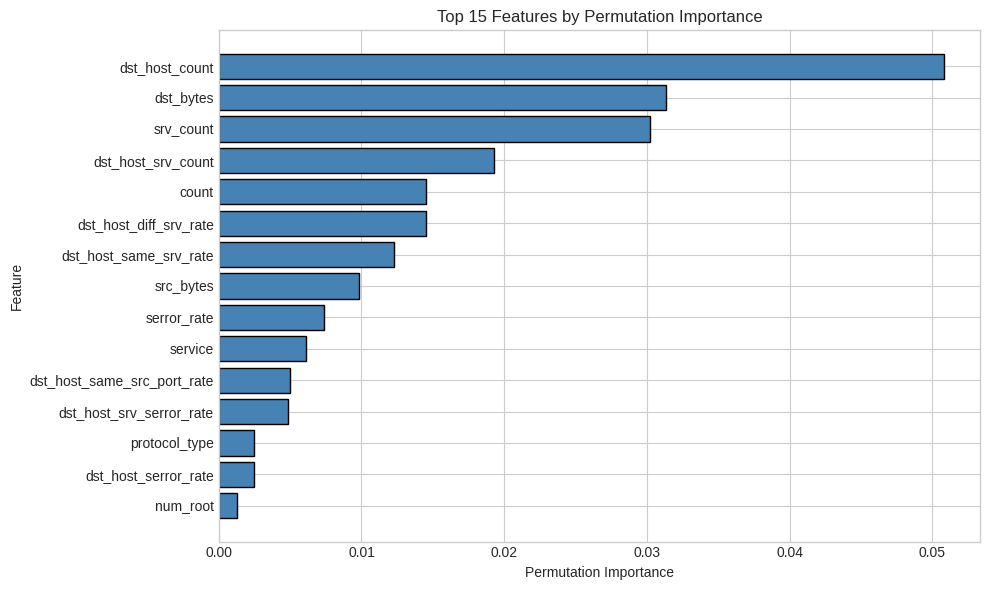

In [26]:
from sklearn.inspection import permutation_importance

x_test_small = x_test[:1000]
y_test_small = y_test[:1000]

# Convert to classification-like scoring
def anomaly_scorer(estimator, x, y):
  pred = estimator.predict(x)
  pred = np.where(pred == -1, 1, 0)
  return f1_score(y, pred)

print("Computing feature importance...")
perm_importance = permutation_importance(
    iso_forest,
    x_test_small,
    y_test_small,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring=anomaly_scorer # Added the custom scorer here
)

#Get the feature names
if len(feature_names) == x_scaled.shape[1]: # Changed x.shape[1] to x_scaled.shape[1]
  feat_names = feature_names
else:
  feat_names = [f'Feature_{i}' for i in range(x_scaled.shape[1])] # Changed x.shape[1] to x_scaled.shape[1]

importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': perm_importance.importances_mean
}).sort_values("Importance", ascending=False)

#Top 15
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1],
         importance_df['Importance'][:15][::-1],
         color='steelblue', edgecolor='black')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 15 Features by Permutation Importance')
plt.tight_layout()
plt.show()

## Summary

### Anomaly Detection Methods

| Method | Idea | Pros | Cons |
|--------|------|------|------|
| **Isolation Forest** | Anomalies isolate faster | Fast, scalable | Contamination param |
| **One-Class SVM** | Boundary around normal | Good with clear boundary | Slow, needs tuning |
| **LOF** | Local density comparison | Finds local anomalies | Slow on large data |

### Key Parameters

| Method | Key Param | Meaning |
|--------|-----------|--------|
| Isolation Forest | contamination | Expected anomaly fraction |
| One-Class SVM | nu | Upper bound on outliers |
| LOF | n_neighbors | Locality definition |

### When to Use

- **Isolation Forest:** Default choice, fast, works well
- **One-Class SVM:** When you have only normal data for training
- **LOF:** When anomalies are local (dense region outliers)

### Evaluation Tips

- With labels: Precision, Recall, F1 (focus on anomaly class)
- Without labels: Score distributions, domain expert review
- Always consider false positive cost vs false negative cost